In [1]:
import math, random
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np

import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F


import seaborn as sns


import sys
if "../../" not in sys.path:
  sys.path.append("../../") 



import collections
import torch.nn as nn

from  collections  import deque
%matplotlib inline

from IPython.display import clear_output

USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)


In [2]:
# %%
# Import numpy modules
from hashlib import new
import numpy as np
from numpy.random import RandomState
from numpy import ndarray, newaxis
from gym import spaces

# Import logging module
import logging
import logging.config

import pyqtgraph as pg
from pyqtgraph.Qt import QtCore, QtGui
import multiprocessing
import time  # needed to wait for window to open

# Setup logger
logger = logging.getLogger(__name__)


class MertonEnvironment:
    def __init__(
        self,
        wealth_0: float,
        rf: float,
        mu: float,
        sigma: float,
        kappa: float,
        stock_price: float = 1.0,
        bond_price: float = 1.0,
        n_paths: int = 1,
        T: int = 1,
        n_discr: int = 1,
        seed: int = None,
        render=False,
    ):
        # If a seed is specified, the algorithm should take this seed
        # for reproducibility purposes. Else do not use a specific seed
        if seed != None:
            self.rng = np.random.RandomState(seed)
            logger.info(f"Stochastic processes initialized with seed {seed}")
        else:
            # This generates a random Random seed each time instead of
            # a fixed seed like in the if case
            self.rng = np.random.RandomState()
            logger.warning("No random seed was used.")

        # The dimensions are necessary to provide the replay buffer with
        # dimensions. We call it observation and action space because
        # this is how it is done in the gym environment from open ai
        # We want to keep the nomenclature so that we are able to call
        # other environments accordingly. See documentation of gym
        # environment
        # self.observation_space = self.ObservationSpace()
        # self.action_space = self.ActionSpace(self.rng, n_paths)
        utes = 15
        u_star = np.linspace(0, 5, utes)
        self.inv_range = u_star
        self.action_space = spaces.Discrete(len(self.inv_range))
        self.observation_space = spaces.Box(0, 120, np.array([2]))
        # print("lol")
        # print(self.action_space.n)
        # Number of trajectories to be simulated. In the easiest case
        # this includes the number of stock trajectories
        self.n_paths = n_paths
        # Number of discretization steps to calculate between starting
        # period (currently T=0) and final period (i.e. T = 100)
        self.n_discr = n_discr
        # Starting wealth of investment
        #! hard coded the wealth, this is bäh
        self.wealth_0 = wealth_0
        self.wealth = self.wealth_0 * np.ones((self.n_paths, 1))
        # Risk free retrun
        self.rf = rf
        # Drift term for calculating stock returns
        self.mu = mu
        # Volatility of the stocks
        self.sigma = sigma
        # Risk aversion parameter for mean variance utility approach
        self.kappa = kappa
        # Stock and Bond prices
        # todo this is the simplest form with only 2 base prices
        self.stock_price = stock_price
        self.bond_price = bond_price
        # Time horizon of investment. Can mean 10 years, can mean 100
        # days. depends on interpretation and rest of the model
        self.T = T
        self.dt = T / n_discr

        # Starting period
        self.t = 0
        # Starting episode. One episode is completed when the agend
        # played once through the lifecycle
        # Number of states corresponds to number of episodes
        self.episode = 0

        # Calculate returns of bonds and stocks
        # self.s, self.b = self.stocks_bonds_growth()

        # Reward range where the 0th entry is the lowest possible reward
        # and the 1st entry is the biggest possible rewards
        self.reward_range = (0, np.inf)

    def step(self, actions: ndarray):

        # print(actions)
        weight = self.inv_range[actions]
        # print(weight)

        # weight = actions.squeeze()

        if self.t < self.n_discr:

            # s_portfolio_return = weight * self.s[:, self.t, np.newaxis]
            s_portfolio_return = np.multiply(weight, self.s[:, self.t] - 1)
            # b_portfolio_return = (1-weight) * self.b[:, self.t, np.newaxis]
            b_portfolio_return = np.multiply(
                (1 - weight), self.b[:, self.t] - 1)

            self.portfolio_growth = s_portfolio_return + b_portfolio_return + 1
            # new_wealth is an absolute value
            self.new_wealth = self.wealth * self.portfolio_growth

            # * Log reward is bäh, better use Mean Variance approach. See
            # Kaiser paper
            # rewards = np.log(self.wealth).flatten()
            rewards = self.reward()
            # states array needs to have shape (n_paths, states)
            # i.e. (5 paths, 2 states) where states is s and portfolio_growth
            states = np.array(
                [self.s[:, self.t], self.portfolio_growth[:]], dtype="float32"
            ).T

            dones = np.repeat(False, self.n_paths)

            final_wealth=0.0
        
            logger.info(
                "Next state reached. Successfully stepped through environment.")
            self.t += 1

        # The else statement functions as the reset of the environment
        else:
            final_wealth = self.new_wealth
            logging.info(f"Environment has reached last step. ({self.t})")
            states = self.reset()
            rewards = self.reward()
            dones = np.repeat(True, self.n_paths)

        # Save as attributes for rendering later on
        # self.rewards = rewards.copy()
        # self.states = states.copy()
        # self.actions = actions.copy()

        return (states, rewards, dones, final_wealth)

    def reset(self):
        # Set time step to 0
        self.t = 0
        logger.info(
            f"""Initial time is t: {self.t}, Number of humans lives or Monte-Carlo-Simulation paths is set to {self.n_paths}."""
        )
        # Calculate returns of bonds and stocks
        self.s, self.b = self.stocks_bonds_growth()
        # Portfolio growth in the first period is 1 (starting wealth)
        self.portfolio_growth = np.ones(self.n_paths)
        # Initialize a wealth array. This currently only includes a
        # fixed wealth wealth_0
        self.new_wealth = self.wealth_0 * np.ones(self.n_paths)
        self.wealth = self.new_wealth

        # The state should correspond to the stock growth rate in the respective
        # time step and the wealth growth rate
        states = np.array(
            [self.s[:, self.t], self.portfolio_growth[:]], dtype="float32"
        ).T
        # Save as attributes for rendering later on
        self.states = states.copy()

        self.t += 1

        return states

    def reward(self):
        d_wealth = self.new_wealth - self.wealth
        # * ----- wealth calculated in relative terms:
        # d_relative_wealth = portfolio_growth - 1
        # this for needs to change state space
        self.wealth = self.new_wealth

        rewards = d_wealth - (self.kappa / 2) * (d_wealth ** 2)
        return rewards.squeeze()

    def stocks_bonds_growth(self):
        # Create a matrix of random variables for calculation of the
        # stock prices via Black Scholes model
        # shape: (trajectories, discretisations)
        z = self.rng.standard_normal((self.n_paths, self.n_discr))

        # Calculate the returns. Working with returns makes it easier
        # to vectorize the calculations
        # s: stock growths
        # b: bonds growths
        s = np.exp(
            (self.mu - 0.5 * self.sigma ** 2) * self.dt
            + self.sigma * np.sqrt(self.dt) * z
        )

        b = np.ones((self.n_paths, self.n_discr)) * np.exp(self.rf * self.dt)
        compound_s = np.cumprod(s)
        compound_b = np.cumprod(b)
        return s, b

    def merton_ratio(self):
        merton_ratio = (self.mu - self.rf) / self.sigma ** 2
        return merton_ratio


In [3]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [4]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. 
                                                                * frame_idx / epsilon_decay)

In [5]:
kappa = 0.008
episodes = 3000000
time_periods = 20
mu =0.10
rf = 0.02
sigma = 0.20

# Relative merton environment
wealth_0 = 100
T_merton = 1
stock_price = 1
bond_price = 1

In [6]:
episodes = episodes #500k worked well? as did 1m

utes = 15
u_star = np.linspace(0,5, utes)

merton_env = MertonEnvironment(
                                wealth_0, 
                                rf, 
                                mu, 
                                sigma, 
                                kappa, 
                                stock_price=stock_price,
                                bond_price=bond_price, 
                                n_paths=1, 
                                T=T_merton, 
                                n_discr=time_periods,
                                seed=0, 
                                render=False,
                                )

In [7]:
# overwrite environment
env = merton_env

for _ in range(1):
    for i in range(time_periods):
        # actions = 2.0
        if i == 0:
            states = env.reset()
        else:
            states, rewards, dones, info = env.step(actions)
            # print(f"{rewards=}")

        # print(states[1])
        actions = np.random.uniform(low=0, high=1, size=(1,))
        
# print(env.action_space.n)

IndexError: arrays used as indices must be of integer (or boolean) type

In [8]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0].item()
            #print(action)
            #print('nromal')
        else:
            action = random.randrange(env.action_space.n)
            #print('rand')
        return action

In [9]:
current_model = DQN(env.observation_space.shape[0], env.action_space.n)
target_model  = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters())

replay_buffer = ReplayBuffer(1000)

In [10]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

In [11]:
update_target(current_model, target_model)

In [12]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = current_model(state)
    next_q_values = current_model(next_state)
    next_q_state_values = target_model(next_state) 

    q_value       = q_values.gather(1, action.unsqueeze(1)).squeeze(1) 
    next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [13]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [14]:
num_frames = 500000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()

for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    
    action = current_model.act(state, epsilon) #norm
    #print(action)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        #print('here')
        loss = compute_td_loss(batch_size)
        losses.append(loss.data[0])
        
    if frame_idx % 400 == 0:
        plot(frame_idx, all_rewards
                         ,np.convolve(losses,np.ones((1000,))/1000,mode='valid'))

    if frame_idx % 100 == 0:
        update_target(current_model, target_model)


TypeError: len() of unsized object

In [15]:
episodes = 100001
# episodes = 2
wealth = 100.0
utilities_mod = []
rewards_mod = []
step_rewards = []
rsum = 0
wealth_episodes = []
number_of_actions = utes

#! This does not make sense. Further down below we change it to use env
# Mark1 = Market(kappa, episodes, time_periods, mu, rf, sigma, u_star)


for i_episode in range(episodes-1):

    if i_episode%10000 ==0:
        print(i_episode)
        
    # state = Mark1.reset() 
    state = env.reset() 
    action = current_model(Variable(torch.FloatTensor(np.float32(state)))).argmax().item()

    while True:    
        # new_state , reward, done, final_wealth = Mark.step(action) #(prop, wealth))
        new_state , reward, done, final_wealth = env.step(action) #(prop, wealth))
        # print(f"{new_state}")
        # print(f"{new_state[:,1]}")
        # print(f"{final_wealth=}")
        action = current_model(Variable(torch.FloatTensor(np.float32(new_state)))).argmax().item()
        rsum += reward
        state = new_state

        #print(new_state)
        #print(model(Variable(torch.FloatTensor(np.float32(new_state)))))
        step_rewards.append(reward)

        if done:
            wealth_episodes.append(final_wealth)
            utilities_mod.append(np.log(final_wealth))
            rewards_mod.append(rsum)
            rsum = 0
            #wealth = 100.0
            # print(i_episode)
            # print(f"{final_wealth=}")
            break 


0
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [16]:
utilities_test = utilities_mod
rewards_test = rewards_mod
step_rew_test = step_rewards
wealth_test = wealth_episodes

In [18]:
import sys
sys.path.insert(0,r'C:\Users\akkon\Documents\programming\ai_wiwi\othermodel')
sys.path.insert(0,r'C:\Users\akkon\Documents\programming\ai_wiwi\other_model\ddqn_relative\lib')
sys.path.insert(0,r'C:\Users\akkon\Documents\programming\ai_wiwi\other_model\ddqn_relative\lib\envs')

from lib.execute_strat import execute_strat
from lib.sim_prices import make_prices
from lib.graphs import make_baseline_graphs, make_agent_graphs, plot_sample_paths, plot_disc_utility, \
                        plot_mv_equiv, plot_const_step

In [25]:
#episodes = 99##3000000
#Q, utilities_mod, rewards_mod, wealth_episodes = train_agent(kappa, episodes)

def make_agent_graphs_new(rewards_test_best, rewards_test_rand, rewards_test,
                      utilities_test_best, utilities_test_rand, utilities_test,
                     wealth_test_rand, wealth_test_best, wealth_test):

    block_utilities_test = np.mean(np.array(utilities_test).reshape(1000,-1),0)
    block_utilities_test_rand = np.mean(np.array(utilities_test_rand).reshape(1000,-1),0)
    block_utilities_test_best = np.mean(np.array(utilities_test_best).reshape(1000,-1),0)


    block_wealth_test_rand = np.mean(np.array(wealth_test_rand).reshape(1000,-1),0)
    block_wealth_test_best = np.mean(np.array(wealth_test_best).reshape(1000,-1),0)
    block_wealth_test = np.mean(np.array(wealth_test).reshape(1000,-1),0)


    block_rewards_test = np.mean(np.array(rewards_test).reshape(1000,-1),0)
    block_rewards_test_rand = np.mean(np.array(rewards_test_rand).reshape(1000,-1),0)
    block_rewards_test_best = np.mean(np.array(rewards_test_best).reshape(1000,-1),0)

    #Calculate sharpe ratios instead of longitudinally do it at the end blocks of 1000 again

    #mu - rf/ sigma
    wr = np.array(wealth_test_rand).reshape(100,-1)
    wr_sharpe = (wr.mean(axis=0)/100-1)/(wr.std(axis=0)/100)

    wt = np.array(wealth_test).reshape(100,-1)
    wt_sharpe = (wt.mean(axis=0)/100-1)/(wt.std(axis=0)/100)

    wb = np.array(wealth_test_best).reshape(100,-1)
    wb_sharpe = (wb.mean(axis=0)/100-1)/(wb.std(axis=0)/100)


    sns.distplot(block_rewards_test_best, label="Merton optimal")
    sns.distplot(block_rewards_test, label="Trained Agent")
    sns.distplot(block_rewards_test_rand, label="Random agent")
    plt.title('Distribution of Final rewards Merton v Trained Agent v Random (per 1000 episodes)')
    plt.xlabel('Episode Rewards')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    plt.violinplot([block_rewards_test_rand, block_rewards_test, block_rewards_test_best])
    plt.xticks([1,2,3], ["Random Agent", "Trained Agent", "Merton Optimal"], rotation=60, size=12)
    plt.ylabel("Test Rewards", size=12)
    plt.xlabel("Agent", size=12)
    ax = plt.gca()
    # ax.set_axis_bgcolor('white')
    ax.grid(0)
    plt.title("Violin plot of Rewards - Random v Merton v Agent")
    plt.show()


    sns.distplot(block_utilities_test_best, label="Merton optimal")
    sns.distplot(block_utilities_test, label="Trained Agent")
    sns.distplot(block_utilities_test_rand, label="Random agent")
    plt.title('Distribution of Final Utilities Merton v Trained Agent v Random (per 1000 episodes)')
    plt.xlabel('Episode Utilities')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    plt.violinplot([block_utilities_test_rand, block_utilities_test, block_utilities_test_best])
    plt.xticks([1,2,3], ["Random Agent", "Trained Agent", "Merton Optimal"], rotation=60, size=12)
    plt.ylabel("Test Utility", size=12)
    plt.xlabel("Agent", size=12)
    ax = plt.gca()
    # ax.set_axis_bgcolor('white')
    ax.grid(0)
    plt.title("Violin plot of utilities - Random v Merton v Agent")
    plt.show()

    plt.plot(np.convolve(utilities_test_best, np.ones((10000,))/10000, mode='valid'), label='Merton Optimal')
    plt.plot(np.convolve(utilities_test_rand, np.ones((10000,))/10000, mode='valid'), label='Random agent')
    plt.plot(np.convolve(utilities_test, np.ones((10000,))/10000, mode='valid'), label='Trained agent')
    plt.title('Moving average 10,000 episode utilities')
    plt.ylabel('Utility')
    plt.xlabel('Episode')
    plt.legend()
    plt.show()

    plt.violinplot([block_wealth_test_rand, block_wealth_test, block_wealth_test_best])
    plt.xticks([1,2,3], ["Random Agent", "Trained Agent", "Merton Optimal"], rotation=60, size=12)
    plt.ylabel("Test Wealth", size=12)
    plt.xlabel("Agent", size=12)
    ax = plt.gca()
    # ax.set_axis_bgcolor('white')
    ax.grid(0)
    plt.title("Violin plot of Wealth - Random v Merton v Agent")
    plt.show()


    sns.distplot(block_wealth_test_best, label="Merton optimal")
    sns.distplot(block_wealth_test, label="Trained Agent")
    sns.distplot(block_wealth_test_rand, label="Random agent")
    plt.title('Distribution of Final Wealth Merton v Trained Agent v Random (per 1000 episodes)')
    plt.xlabel('Episode Wealth')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    plt.violinplot([wr_sharpe, wt_sharpe, wb_sharpe])
    plt.xticks([1,2,3], ["Random Agent", "Trained Agent", "Merton Optimal"], rotation=60, size=12)
    plt.ylabel("Test Sharpe", size=12)
    plt.xlabel("Agent", size=12)
    ax = plt.gca()
    # ax.set_axis_bgcolor('white')
    ax.grid(0)
    plt.title("Violin plot of Sharpe ratios (M period) - Random v Merton v Agent")
    plt.show()

    sns.distplot(wb_sharpe, label="Merton optimal")
    sns.distplot(wt_sharpe, label="Trained Agent")
    sns.distplot(wr_sharpe, label="Random agent")
    plt.title('Distribution of Final Sharpe ratios  Merton v Trained Agent v Random (per 1000 episodes)')
    plt.xlabel('Episode Sharpe')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    return block_utilities_test_rand, block_utilities_test, block_utilities_test_best, \
           block_rewards_test_rand, block_rewards_test, block_rewards_test_best, \
           block_wealth_test_rand, block_wealth_test, block_wealth_test_best, \
           wr_sharpe, wt_sharpe, wb_sharpe

In [20]:
wealth = 100.0

merton_ratio = (mu-rf)/sigma**2
best_action = np.argmin(np.abs(u_star-merton_ratio))
#temp change to execute strat
utilities_test_rand, rewards_test_rand, step_rew_rand, wealth_test_rand = execute_strat(kappa,mu, 
                                                                      rf, sigma, utes,u_star,best_action, 'Random',
                                                                      episodes=100001,
                                                                      time_periods=time_periods, wealth=wealth)
utilities_test_best, rewards_test_best, step_rew_best, wealth_test_best = execute_strat(kappa, mu, rf, sigma, 
                                                                      utes, u_star, best_action,'Merton', 
                                                                      episodes=100001,
                                                                      time_periods=time_periods, wealth=wealth)

C:\Users\Sascha\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Sascha\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Sascha\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

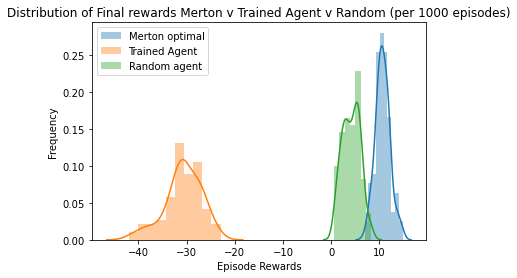

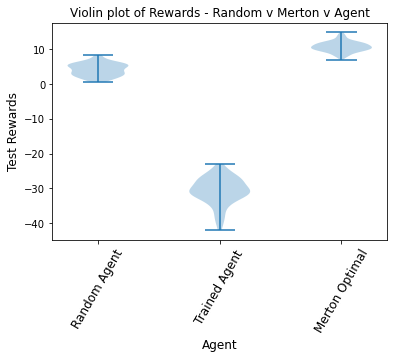

C:\Users\Sascha\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Sascha\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Sascha\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

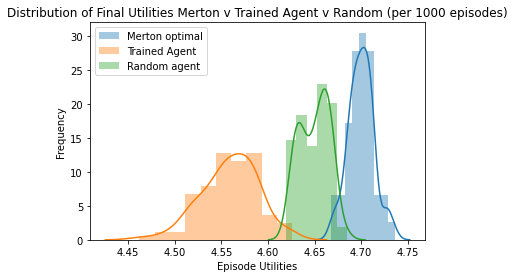

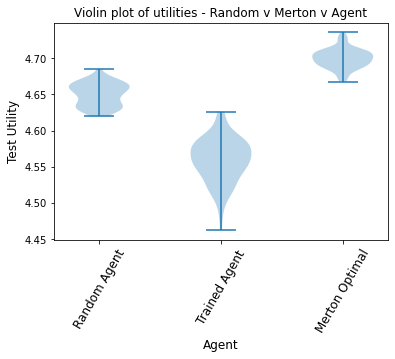

ValueError: object too deep for desired array

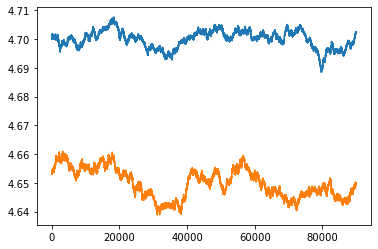

In [26]:
#utilities_test, rewards_test, step_rew_test, wealth_test = execute_strat(kappa, mu, rf, sigma, utes, u_star,best_action, 
#                                                            'Agent', q_values=Q, 
#                                                            time_periods=time_periods, wealth=wealth)

results = make_agent_graphs_new(rewards_test_best, rewards_test_rand, rewards_test,
                  utilities_test_best, utilities_test_rand, utilities_test,
                         wealth_test_rand, wealth_test_best, wealth_test)

In [ ]:
for r in results:
    print(np.mean(r))

4.647705717839808
4.701881007676416
4.700574399289017
3.785101694147847
10.857694452225248
10.680781864955206
123.22127414001936
120.16502411878824
119.97156581621101
0.3071353927660123
0.39031087515516705
0.38656642141334224


In [ ]:
for r in results:
    print(np.std(r))

0.01960570304115883
0.013054563404349621
0.013365193028326545
2.044535685985809
1.522981989512418
1.5608712810229721
2.4921318368608323
1.6696088372423477
1.7272311660207156
0.07901668508882188
0.0795374141722387
0.08426202053242544
